<a href="https://colab.research.google.com/github/auxten/data-sdk/blob/main/demo_etl.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!git clone https://github.com/auxten/data-sdk


fatal: destination path 'data-sdk' already exists and is not an empty directory.


In [ ]:
%cd data-sdk
!pip install -r requirements.txt

/content/data-sdk


# API as a Table

<img width="598" alt="Image" src="https://github.com/user-attachments/assets/43c22356-ce18-46e5-8a0e-20d02de944b3" />

In [ ]:
import os
if "ANTHROPIC_API_KEY" not in os.environ or os.environ["ANTHROPIC_API_KEY"] == "":
  from getpass import getpass
  anthropic_api_key = getpass("Input your anthropic api key")
  os.environ["ANTHROPIC_API_KEY"]=anthropic_api_key

from datasource import DataSource
from agent import Agent, ANTHROPIC_API_KEY

# Use a Pandas-style connection configuration approach with unified interface
# chDB can use any Python function or API as a table
revenuecat = DataSource.connect(
    "API",
    url="http://localhost:8000/v1",
    api_key="",
)

## Select and Filter data, but not executed

In [ ]:
# select() method to specify fields
# Allows more granular control over returned data
users = revenuecat.collection("users").select("id, name, subscription_status")

# filter method with multiple operator support
# More expressive filtering operations with SQL-like clarity
active_users = users.filter("subscription_status", "=", "active")

print(active_users)


Input your anthropic api key··········
SELECT users.id, users.name, users.subscription_status FROM Python(reader) AS users WHERE users.subscription_status = 'active'


# CSV as a table

<img width="745" alt="Image" src="https://github.com/user-attachments/assets/8ecd0238-5b27-4758-baa1-8d798ebcd0e1" />

In [ ]:
# Database connections use the same unified interface
# Consistency across different data sources reduces cognitive load
# db = DataSource.connect(
#     "postgres", host="localhost", database="mydb", user="user", password="xxx"
# )

# File source connection (CSV)
db = DataSource.connect("file", path="data/comments.csv", format="CSV")

# SQL syntax sugar while maintaining DataFrame-style interface
# Familiar SQL concepts merged with modern object chaining
comments = db.table("comments").select("*")

# JOIN 2 data sources

<img width="500" alt="Image" src="https://github.com/user-attachments/assets/018f29d5-ab8a-4504-93f9-57f41ae19513" />

In [ ]:
# Add Pandas-style relational queries
# Enhanced join operations with clear relation definition
subscribed_user_comments = active_users.join(
    comments, on={"users.id": "comments.user_id"}
)

# Pandas-style pagination and limitations
# Efficient data handling without loading unnecessary records
sample = subscribed_user_comments.limit(1000)

# Show the query
print("Query:")
print(sample)

# Execute the query and show results
print("\nResults:")
print(sample.execute())

# Execute with different output formats
# print("\nResults as JSON:")
# print(sample.execute(output_format="JSON"))


Query Plan:
SELECT users.id, users.name, users.subscription_status, comments.* FROM Python(reader) AS users JOIN file('data/comments.csv', 'CSV') AS comments ON users.id=comments.user_id WHERE users.subscription_status = 'active' LIMIT 1000

Results:
    ┌─id─┬─name────────────┬─subscription_status─┬─user_id─┬─comment_text─────────────────────────────────────┬─comments.created_at─┬─likes─┐
 1. │  1 │ John Doe        │ active              │       1 │ Great product! Really love the features.         │ 2023-01-15 10:30:00 │     5 │
 2. │  1 │ John Doe        │ active              │       1 │ Customer support was very helpful.               │ 2023-01-17 14:20:00 │     3 │
 3. │  1 │ John Doe        │ active              │       1 │ Would recommend to others.                       │ 2023-01-21 10:00:00 │     6 │
 4. │  1 │ John Doe        │ active              │       1 │ Great value for money.                           │ 2023-01-24 14:45:00 │     7 │
 5. │  1 │ John Doe        │ active    

In [ ]:
# Use the question function to generate SQL from natural language
analysis = sample.question("accumulate the total comments count for each user")
print("SQL generated by Agent:")
print(analysis)


SQL generated by Agent:
SELECT 
    users.id, 
    users.name, 
    users.subscription_status, 
    COUNT(comments.user_id) AS total_comments
FROM Python(reader) AS users 
JOIN file('data/comments.csv', 'CSV') AS comments ON (users.id = comments.user_id) 
WHERE users.subscription_status = 'active'
GROUP BY 
    users.id, 
    users.name, 
    users.subscription_status
ORDER BY total_comments DESC
LIMIT 1000


In [ ]:
print("Results from SQL:")
print(analysis.execute())

# Rich output format options
# Multiple export formats for different downstream needs
result = analysis.to_dataframe()  # Return pandas DataFrame
print(result)
result = analysis.to_dict()  # Return dictionary structure
print(result)


Results from SQL:
    ┌─id─┬─name────────────┬─subscription_status─┬─total_comments─┐
 1. │  1 │ John Doe        │ active              │              7 │
 2. │  3 │ Bob Smith       │ active              │              5 │
 3. │ 16 │ Mary White      │ active              │              1 │
 4. │  6 │ Emily Davis     │ active              │              1 │
 5. │ 10 │ Lisa Anderson   │ active              │              1 │
 6. │  8 │ Sarah Wilson    │ active              │              1 │
 7. │ 13 │ Robert Garcia   │ active              │              1 │
 8. │ 11 │ James Taylor    │ active              │              1 │
 9. │  5 │ Bob Johnson     │ active              │              1 │
10. │ 18 │ Elizabeth Clark │ active              │              1 │
11. │ 20 │ Nancy Hall      │ active              │              1 │
12. │ 15 │ William Lee     │ active              │              1 │
    └────┴─────────────────┴─────────────────────┴────────────────┘

    id             name subsc

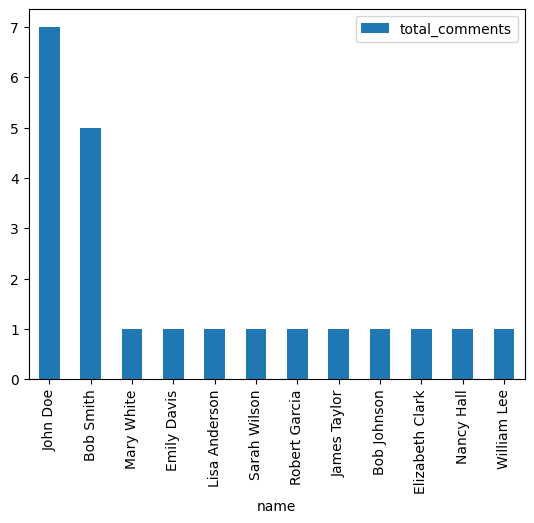

In [ ]:
analysis.plot(x="name", y="total_comments", kind="bar")